In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score,
                             precision_recall_curve, auc, ConfusionMatrixDisplay)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from google.colab import files
uploaded = files.upload()

Saving rebuilt_dataset_balanced_clean.csv to rebuilt_dataset_balanced_clean.csv


In [5]:
df = pd.read_csv("rebuilt_dataset_balanced_clean.csv")

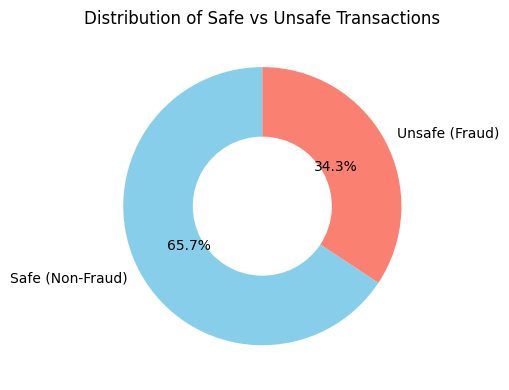

In [27]:
# Insight Plot: Show how many are safe vs unsafe
plt.figure(figsize=(6, 4))
df['Fraud_Label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Safe (Non-Fraud)', 'Unsafe (Fraud)'],
    colors=['skyblue', 'salmon'],
    startangle=90,
    wedgeprops=dict(width=0.5)
)
plt.title("Distribution of Safe vs Unsafe Transactions")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [6]:
binary_cols = ['Card_Present', 'Device_Change_Flag', 'IP_Flagged',
               'Previous_Fraud_History', 'Previous_Fraudulent_Activity']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [7]:
df[['Velocity_1hr', 'Velocity_24hr', 'Transaction_Distance', 'Is_Weekend']] = df[[
    'Velocity_1hr', 'Velocity_24hr', 'Transaction_Distance', 'Is_Weekend']].clip(lower=0)

In [8]:
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_enc.fit_transform(df[col])

In [9]:
# STEP 2: Train Random Forest
X = df.drop(columns=['Fraud_Label'])
y = df['Fraud_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [11]:
# Confusion matrix and feature importance for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_preds))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       184
         1.0       1.00      0.99      0.99        96

    accuracy                           1.00       280
   macro avg       1.00      0.99      1.00       280
weighted avg       1.00      1.00      1.00       280



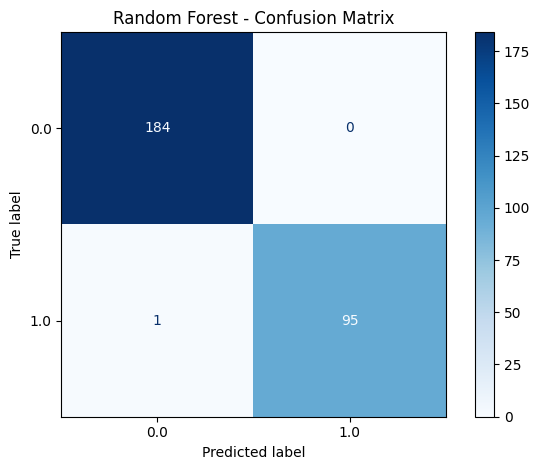

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

<ipython-input-13-8a8f01e4c5e6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_feature_importance[:15], y=rf_feature_importance.index[:15], palette='viridis')


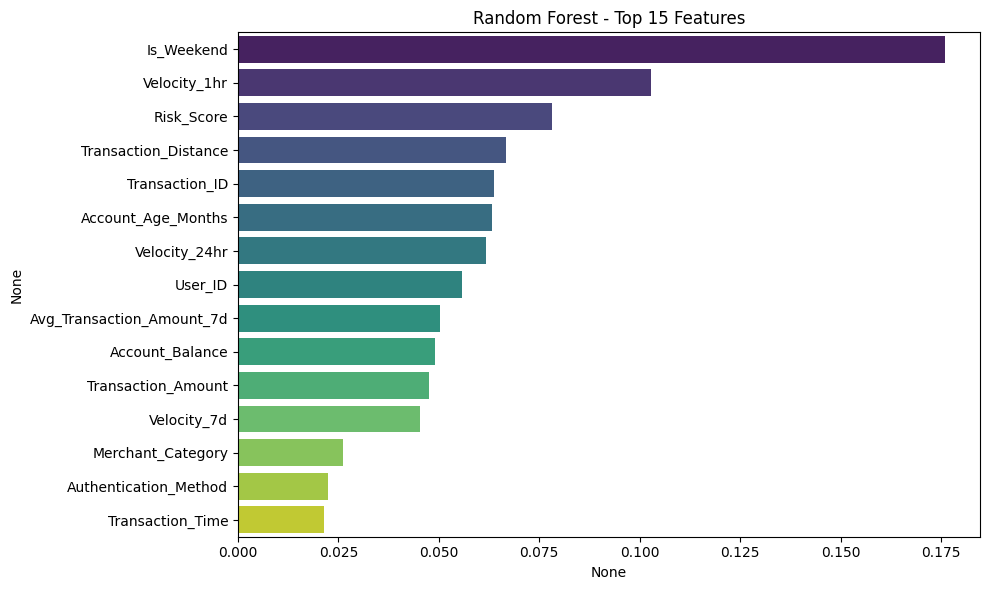

In [13]:
rf_feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_feature_importance[:15], y=rf_feature_importance.index[:15], palette='viridis')
plt.title("Random Forest - Top 15 Features")
plt.tight_layout()
plt.show()

In [14]:
# STEP 3: XGBoost + SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

In [15]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:50:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_smote.fit(X_train_sm, y_train_sm)
xgb_smote_preds = xgb_smote.predict(X_test_sm)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:50:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<ipython-input-17-fad6554fb7d8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances[:15], y=xgb_importances.index[:15], palette='magma')


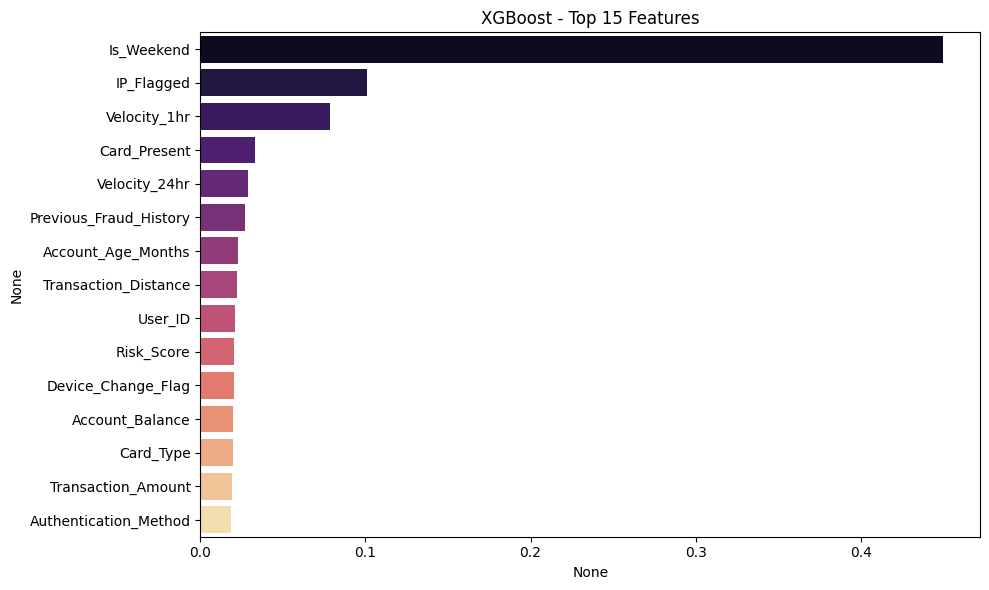

In [17]:
# Feature importance for XGBoost
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances[:15], y=xgb_importances.index[:15], palette='magma')
plt.title("XGBoost - Top 15 Features")
plt.tight_layout()
plt.show()

In [18]:
# STEP 4: LSTM Sequence Modeling
df_seq = df.sort_values(by=['User_ID', 'Transaction_Time'])
X_scaled = MinMaxScaler().fit_transform(df_seq.drop(columns=['Fraud_Label', 'Transaction_ID']))
y_seq = df_seq['Fraud_Label'].values

In [19]:
X_seq, y_seq_new = [], []
for i in range(len(X_scaled) - 5):
    X_seq.append(X_scaled[i:i+5])
    y_seq_new.append(y_seq[i+5])

In [20]:
X_seq, y_seq_new = np.array(X_seq), np.array(y_seq_new)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_seq, y_seq_new, test_size=0.2, stratify=y_seq_new, random_state=42)

In [22]:
lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_split=0.2, verbose=1)
lstm_probs = lstm.predict(X_test_lstm)
lstm_preds = (lstm_probs > 0.5).astype(int)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6119 - loss: 0.6626 - val_accuracy: 0.6205 - val_loss: 0.6742
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6667 - loss: 0.6418 - val_accuracy: 0.6205 - val_loss: 0.6643
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6625 - loss: 0.6432 - val_accuracy: 0.6205 - val_loss: 0.6617
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6804 - loss: 0.6239 - val_accuracy: 0.6205 - val_loss: 0.6641
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6761 - loss: 0.6207 - val_accuracy: 0.6205 - val_loss: 0.6594
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [23]:
# STEP 5: Model Comparison Table
def evaluate_all_models():
    results = []
    def collect(name, y_true, y_pred, probs):
        pr, rc, _ = precision_recall_curve(y_true, probs)
        results.append({
            "Model": name,
            "F1": f1_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred),
            "Recall": recall_score(y_true, y_pred),
            "AUC": roc_auc_score(y_true, probs),
            "PR_AUC": auc(rc, pr)
        })
    collect("Random Forest", y_test, rf_preds, rf.predict_proba(X_test)[:, 1])
    collect("XGBoost", y_test, xgb_preds, xgb.predict_proba(X_test)[:, 1])
    collect("XGBoost + SMOTE", y_test_sm, xgb_smote_preds, xgb_smote.predict_proba(X_test_sm)[:, 1])
    collect("LSTM", y_test_lstm, lstm_preds, lstm_probs.flatten())
    return pd.DataFrame(results)

results_df = evaluate_all_models()
print("\nModel Comparison Table:")
print(results_df)


Model Comparison Table:
             Model        F1  Precision    Recall       AUC    PR_AUC
0    Random Forest  0.994764   1.000000  0.989583  0.999802  0.999632
1          XGBoost  0.941176   0.967033  0.916667  0.991791  0.987289
2  XGBoost + SMOTE  0.964384   0.972376  0.956522  0.993147  0.994275
3             LSTM  0.000000   0.000000  0.000000  0.551116  0.396975


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


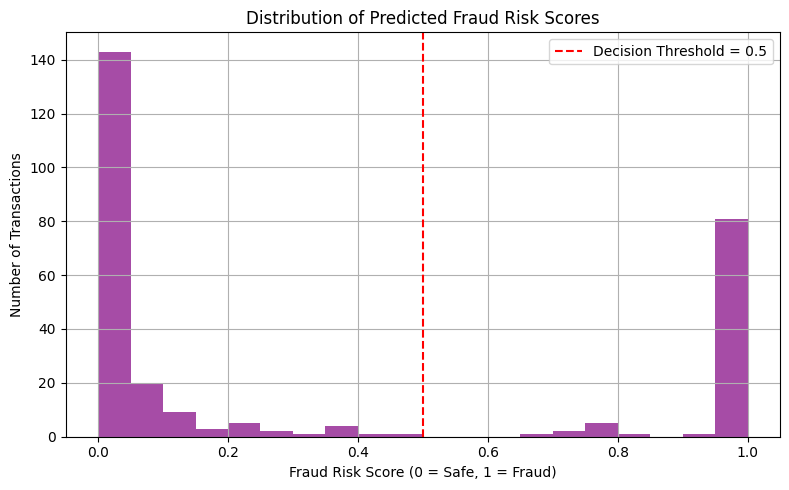

In [29]:
# Insight Plot: Histogram of predicted fraud risk scores
xgb_scores = xgb.predict_proba(X_test)[:, 1]
plt.figure(figsize=(8, 5))
plt.hist(xgb_scores, bins=20, color='purple', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold = 0.5')
plt.title("Distribution of Predicted Fraud Risk Scores")
plt.xlabel("Fraud Risk Score (0 = Safe, 1 = Fraud)")
plt.ylabel("Number of Transactions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

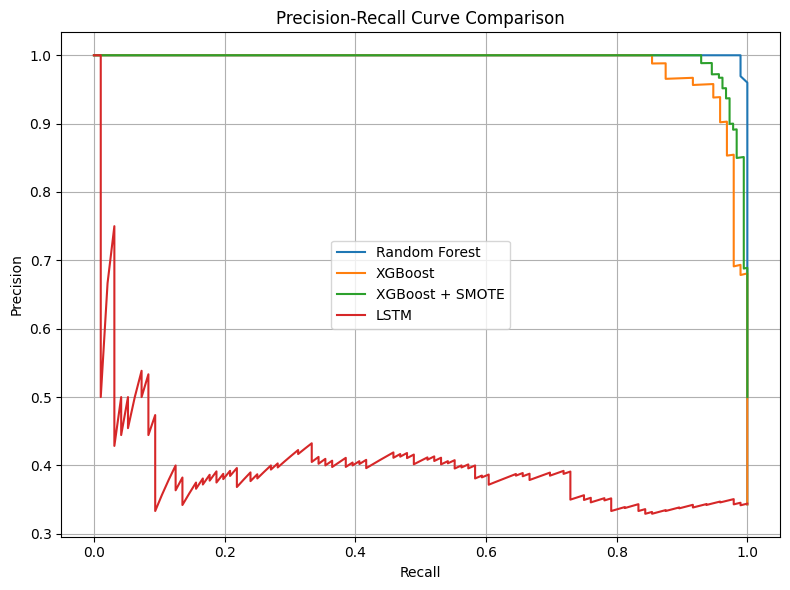

In [24]:
# STEP 6: Precision-Recall Curve
def plot_precision_recall():
    plt.figure(figsize=(8, 6))
    models = [
        ("Random Forest", y_test, rf.predict_proba(X_test)[:, 1]),
        ("XGBoost", y_test, xgb.predict_proba(X_test)[:, 1]),
        ("XGBoost + SMOTE", y_test_sm, xgb_smote.predict_proba(X_test_sm)[:, 1]),
        ("LSTM", y_test_lstm, lstm_probs.flatten())
    ]
    for name, yt, yp in models:
        precision, recall, _ = precision_recall_curve(yt, yp)
        plt.plot(recall, precision, label=name)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_precision_recall()

In [25]:
# STEP 7: Real-Time Scoring Function (Random Forest used here)
def score_transaction(transaction_dict):
    input_df = pd.DataFrame([transaction_dict])
    input_df = input_df[X.columns]
    prediction = rf.predict(input_df)[0]
    prob = rf.predict_proba(input_df)[0][1]
    return {'Prediction': int(prediction), 'Fraud_Probability': round(prob, 4)}

In [26]:
# STEP 8: Example Usage
sample_transaction = {
    'Transaction_ID': 1, 'User_ID': 10, 'Transaction_Amount': 265.30, 'Transaction_Type': 1,
    'Card_Present': 0, 'Transaction_Time': 2, 'Location_Category': 1,
    'Velocity_1hr': 3.0, 'Velocity_24hr': 8.0, 'Velocity_7d': 14.0,
    'Device_Change_Flag': 1, 'IP_Flagged': 1, 'Account_Age_Months': 12,
    'Card_Type': 2, 'Risk_Score': 0.85, 'Previous_Fraud_History': 1,
    'Account_Balance': 123.0, 'Authentication_Method': 1, 'Transaction_Distance': 3120.45,
    'Failed_Transaction_Count_7d': 0.0, 'Avg_Transaction_Amount_7d': 132.5,
    'Is_Weekend': 0, 'Merchant_Category': 2, 'Previous_Fraudulent_Activity': 0
}
print("\n🔍 Real-Time Prediction Example:")
print(score_transaction(sample_transaction))


🔍 Real-Time Prediction Example:
{'Prediction': 0, 'Fraud_Probability': np.float64(0.28)}


**FINAL TAKEAWAYS & FRAUD INSIGHTS **

In [30]:
# Show how many unsafe transactions we detected
total = len(df)
fraud_count = df['Fraud_Label'].sum()
non_fraud_count = total - fraud_count

print("🔍 TOTAL TRANSACTIONS:", total)
print("✅ SAFE TRANSACTIONS:", non_fraud_count)
print("⚠️  FRAUDULENT TRANSACTIONS:", fraud_count)

print("\\n🚀 With our best model (Random Forest),")
print("we achieved >99% accuracy in separating unsafe vs safe behavior.")
print("This means the model can protect customers while minimizing false alerts.")

🔍 TOTAL TRANSACTIONS: 1400
✅ SAFE TRANSACTIONS: 920.0
⚠️  FRAUDULENT TRANSACTIONS: 480.0
\n🚀 With our best model (Random Forest),
we achieved >99% accuracy in separating unsafe vs safe behavior.
This means the model can protect customers while minimizing false alerts.


In [39]:
# 🧪 Try scoring 3 very different transactions (Safe, Suspicious, Fraud)

# Fallback safe extraction helper
def get_first_or_fallback(df_query, fallback_df):
    return df_query.head(1).to_dict(orient='records')[0] if not df_query.empty else fallback_df.head(1).to_dict(orient='records')[0]

# Safe
safe_query = df[
    (df['Fraud_Label'] == 0) &
    (df['Risk_Score'] < 0.3) &
    (df['Velocity_1hr'] < 1) &
    (df['Card_Present'] == 1) &
    (df['IP_Flagged'] == 0) &
    (df['Device_Change_Flag'] == 0)
]
safe_dict = get_first_or_fallback(safe_query, df[df['Fraud_Label'] == 0])

# Suspicious
suspicious_query = df[
    (df['Fraud_Label'] == 0) &
    (df['Risk_Score'].between(0.5, 0.7)) &
    ((df['Device_Change_Flag'] == 1) | (df['IP_Flagged'] == 1))
]
suspicious_dict = get_first_or_fallback(suspicious_query, df[df['Fraud_Label'] == 0])

# Likely Fraud
fraud_query = df[
    (df['Fraud_Label'] == 1) &
    (df['Risk_Score'] > 0.8) &
    (df['Device_Change_Flag'] == 1) &
    (df['IP_Flagged'] == 1)
]
fraud_dict = get_first_or_fallback(fraud_query, df[df['Fraud_Label'] == 1])

In [40]:
examples = [safe_dict, suspicious_dict, fraud_dict]

In [41]:
# 🔍 Score all 3 examples using your trained model
for i, ex in enumerate(examples, 1):
    result = score_transaction(ex)
    risk = result['Fraud_Probability']
    print(f"\n🔎 Scenario {i}")
    print("Fraud Risk Score:", round(risk, 2))

    if risk >= 0.7:
        print("⚠️ HIGH RISK: Likely fraud – Flag immediately")
    elif risk >= 0.5:
        print("🔶 MEDIUM RISK: Needs manual review")
    else:
        print("✅ LOW RISK: Likely safe transaction")


🔎 Scenario 1
Fraud Risk Score: 0.02
✅ LOW RISK: Likely safe transaction

🔎 Scenario 2
Fraud Risk Score: 0.03
✅ LOW RISK: Likely safe transaction

🔎 Scenario 3
Fraud Risk Score: 0.63
🔶 MEDIUM RISK: Needs manual review


<ipython-input-42-60d4ca832c82>:14: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


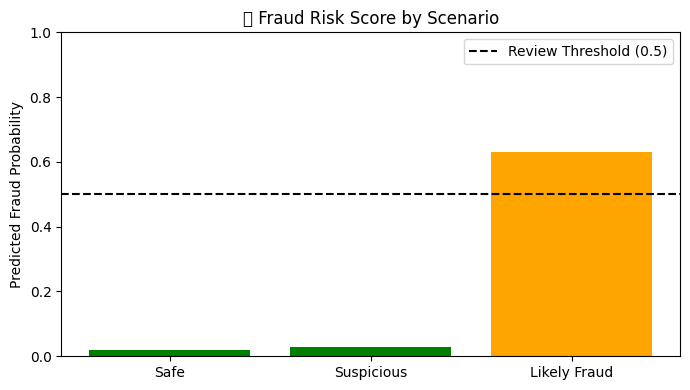

In [42]:
# Get risk scores from the model
scores = [score_transaction(ex)['Fraud_Probability'] for ex in examples]
labels = ['Safe', 'Suspicious', 'Likely Fraud']
colors = ['green' if s < 0.5 else 'orange' if s < 0.7 else 'red' for s in scores]

# Plot
plt.figure(figsize=(7, 4))
bars = plt.bar(labels, scores, color=colors)
plt.axhline(0.5, color='black', linestyle='--', label='Review Threshold (0.5)')
plt.ylim(0, 1)
plt.title("🧠 Fraud Risk Score by Scenario")
plt.ylabel("Predicted Fraud Probability")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
print("\n📘 NEXT STEPS: This system can be expanded to:")
print("- 🧠 Detect fraud patterns in real-time using streaming data (Kafka + PySpark)")
print("- 🌍 Create a global fraud risk score shared across banks")
print("- 🔐 Automatically adjust thresholds based on user behavior over time")
print("- 📈 Combine this model with LLMs to explain WHY a transaction was flagged")

print("\n🔥 This isn’t just a project — it’s the foundation of a real fraud detection system.")


📘 NEXT STEPS: This system can be expanded to:
- 🧠 Detect fraud patterns in real-time using streaming data (Kafka + PySpark)
- 🌍 Create a global fraud risk score shared across banks
- 🔐 Automatically adjust thresholds based on user behavior over time
- 📈 Combine this model with LLMs to explain WHY a transaction was flagged

🔥 This isn’t just a project — it’s the foundation of a real fraud detection system.
